# Sound Realty House Price Prediction - Model Evaluation and Improvement

This notebook contains:
1. Initial model evaluation
2. Exploratory Data Analysis (EDA)
3. Model improvements

Let's start by importing necessary libraries and loading our data.

In [9]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import matplotlib.pyplot as plt
import seaborn as sns
import json
import warnings
import pickle

# Suppress all warnings
warnings.filterwarnings('ignore')

# Set style for plots
plt.style.use('seaborn')
sns.set_palette('deep')
plt.rcParams['figure.figsize'] = [10, 6]

# Load the data
house_data = pd.read_csv('data/kc_house_data.csv', dtype={'zipcode': str})
demographics = pd.read_csv('data/zipcode_demographics.csv', dtype={'zipcode': str})

## 1. Initial Model Evaluation

Let's evaluate the current model's performance by:
1. Loading the trained model
2. Preparing a test dataset
3. Calculating key metrics
4. Analyzing prediction errors

In [10]:
# Load the trained model and features
with open('model/model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('model/model_features.json', 'r') as f:
    model_features = json.load(f)

# Prepare the dataset
merged_data = house_data.merge(demographics, on='zipcode', how='left')
X = merged_data[model_features]
y = merged_data['price']

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Make predictions
y_pred = model.predict(X_test)

# Calculate metrics
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Model Performance Metrics:")
print(f"RMSE: ${rmse:,.2f}")
print(f"MAE: ${mae:,.2f}")
print(f"R² Score: {r2:.4f}")

Model Performance Metrics:
RMSE: $202,625.48
MAE: $102,336.78
R² Score: 0.7284


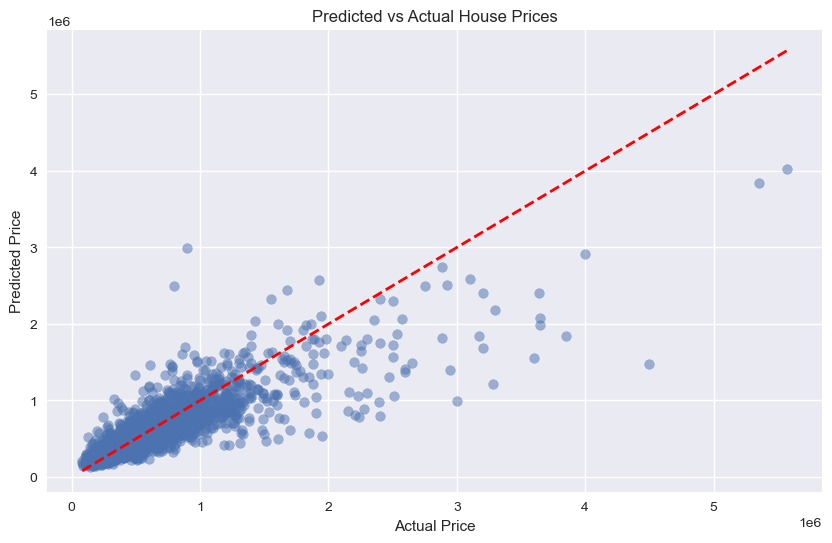

In [11]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Actual Price')
plt.ylabel('Predicted Price')
plt.title('Predicted vs Actual House Prices')
plt.show()

## 2. Exploratory Data Analysis (EDA)

Let's analyze our data to understand:
1. Distribution of house prices
2. Feature correlations
3. Potential outliers
4. Missing values

In [12]:
house_data.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [13]:
demographics.head()

,ppltn_qty,urbn_ppltn_qty,sbrbn_ppltn_qty,farm_ppltn_qty,non_farm_qty,medn_hshld_incm_amt,medn_incm_per_prsn_amt,hous_val_amt,edctn_less_than_9_qty,edctn_9_12_qty,...,per_farm,per_non_farm,per_less_than_9,per_9_to_12,per_hsd,per_some_clg,per_assoc,per_bchlr,per_prfsnl,zipcode
0,38249.0,37394.0,0.0,0.0,855.0,66051.0,25219.0,192000.0,437.0,2301.0,...,0.0,2.0,1.0,6.0,18.0,20.0,5.0,12.0,4.0,98042
1,22036.0,22036.0,0.0,0.0,0.0,91904.0,53799.0,573900.0,149.0,404.0,...,0.0,0.0,0.0,1.0,6.0,12.0,3.0,27.0,22.0,98040
2,18194.0,18194.0,0.0,0.0,0.0,61813.0,31765.0,246600.0,269.0,905.0,...,0.0,0.0,1.0,4.0,13.0,20.0,6.0,19.0,9.0,98028
3,21956.0,21956.0,0.0,0.0,0.0,47461.0,22158.0,175400.0,925.0,1773.0,...,0.0,0.0,4.0,8.0,20.0,21.0,5.0,12.0,4.0,98178
4,22814.0,22814.0,0.0,0.0,0.0,48606.0,28398.0,252600.0,599.0,1148.0,...,0.0,0.0,2.0,5.0,13.0,17.0,5.0,23.0,12.0,98007


House Price Statistics:
count    2.161300e+04
mean     5.400881e+05
std      3.671272e+05
min      7.500000e+04
25%      3.219500e+05
50%      4.500000e+05
75%      6.450000e+05
max      7.700000e+06
Name: price, dtype: float64


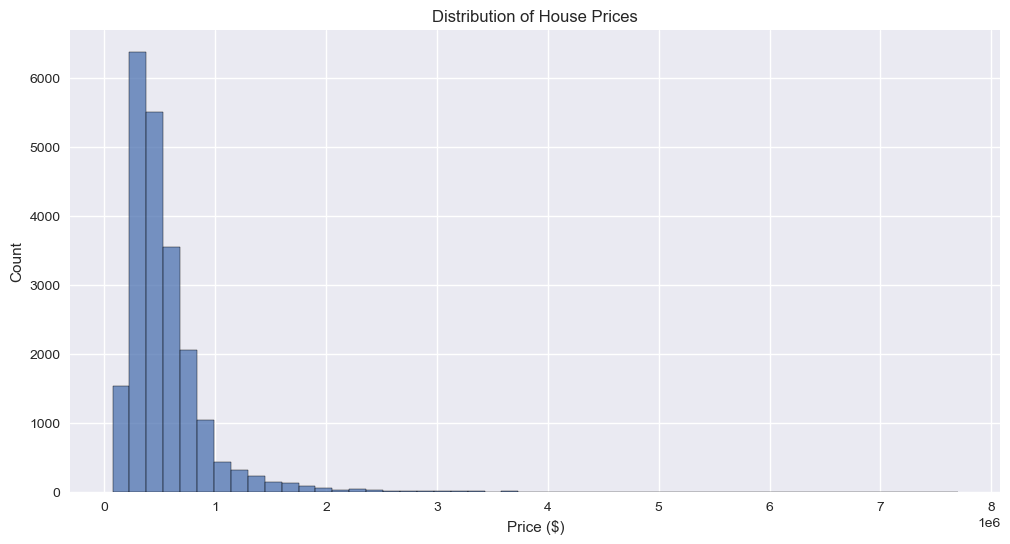

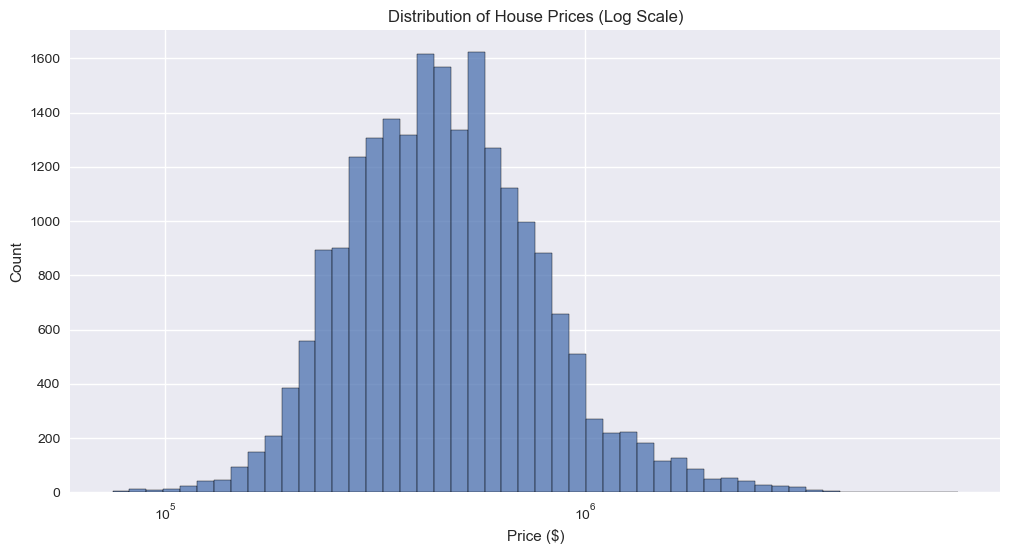

In [14]:
# Basic statistics of the price distribution
print("House Price Statistics:")
price_stats = house_data['price'].describe()
print(price_stats)

# Plot price distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=house_data, x='price', bins=50)
plt.title('Distribution of House Prices')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.show()

# Log-transformed price distribution
plt.figure(figsize=(12, 6))
sns.histplot(data=house_data, x='price', bins=50, log_scale=True)
plt.title('Distribution of House Prices (Log Scale)')
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.show()

### Feature Correlations

Let's examine how different features correlate with house prices.

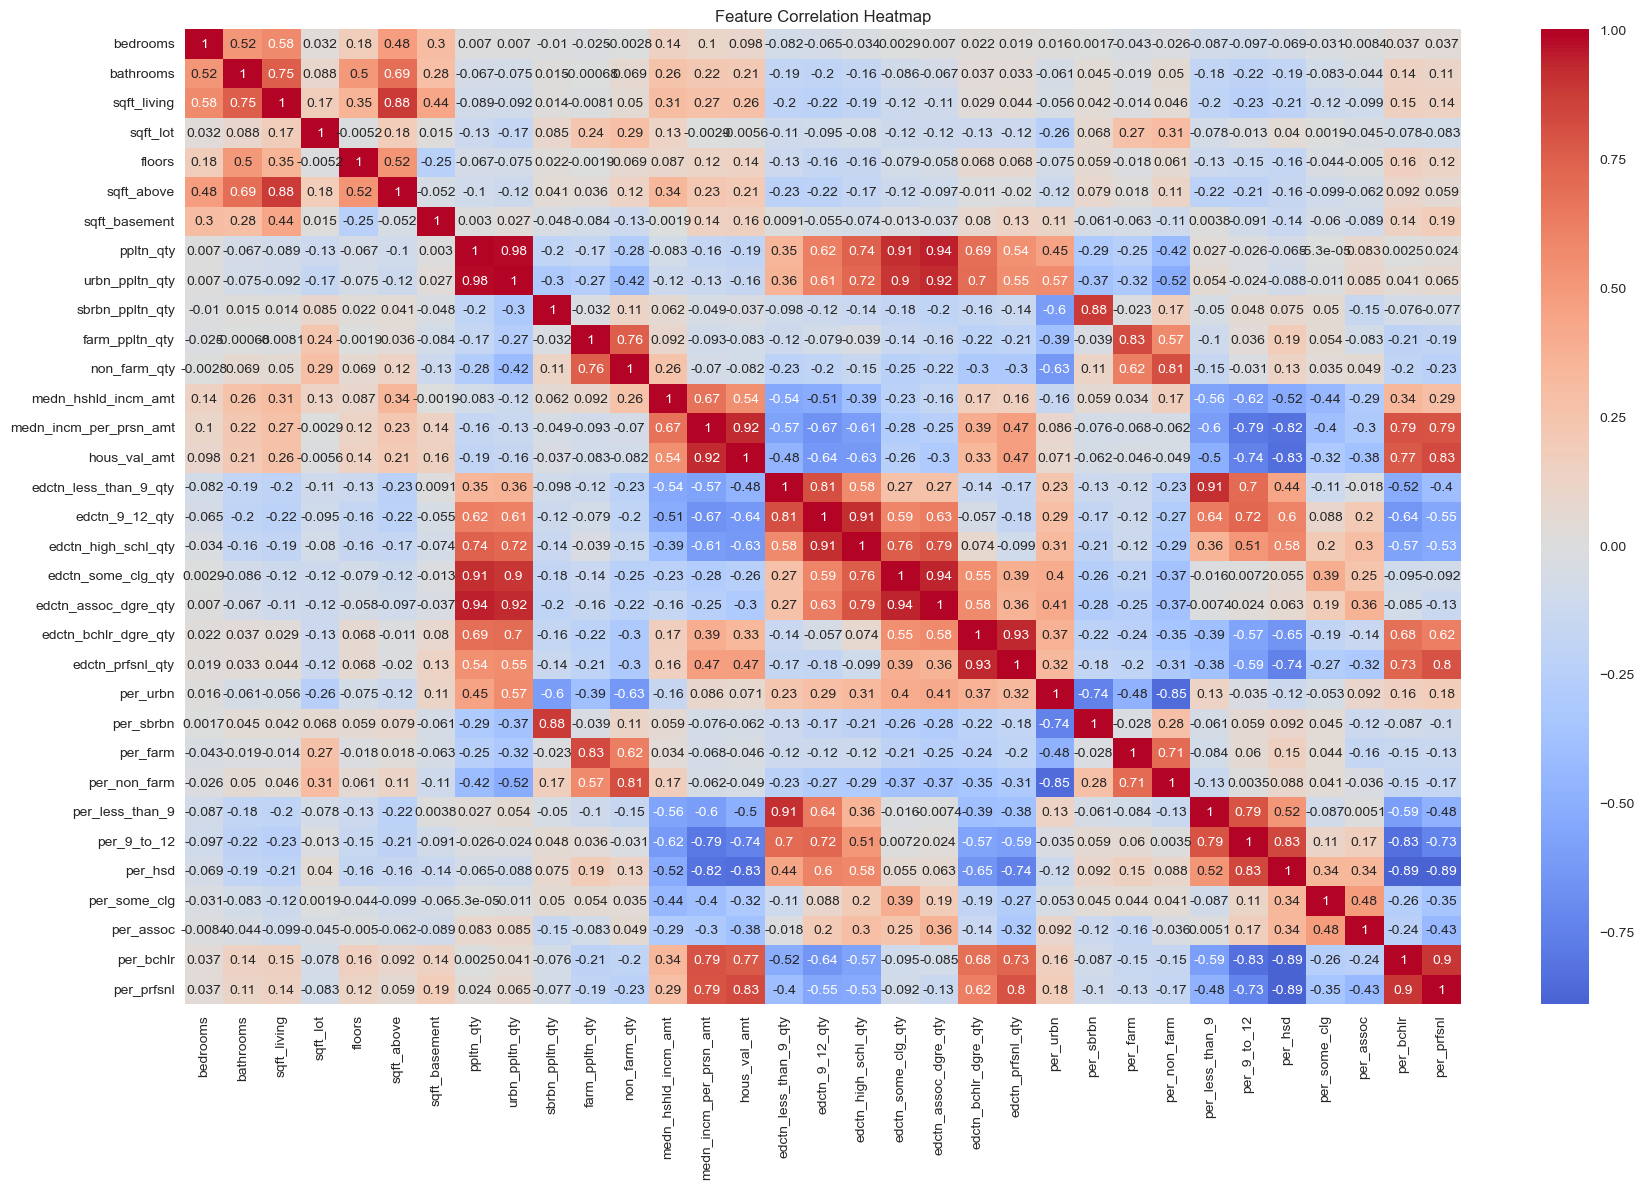


Correlations with Price:
sqft_living               0.702035
sqft_above                0.605567
hous_val_amt              0.579733
medn_incm_per_prsn_amt    0.549911
bathrooms                 0.525138
per_prfsnl                0.500262
per_bchlr                 0.474896
sqft_basement             0.323816
bedrooms                  0.308350
edctn_prfsnl_qty          0.291694
medn_hshld_incm_amt       0.272460
floors                    0.256794
edctn_bchlr_dgre_qty      0.209238
sqft_lot                  0.089661
per_urbn                  0.068983
per_sbrbn                -0.023602
sbrbn_ppltn_qty          -0.028090
per_farm                 -0.062706
per_non_farm             -0.075340
urbn_ppltn_qty           -0.093640
farm_ppltn_qty           -0.101311
non_farm_qty             -0.118589
ppltn_qty                -0.123181
edctn_some_clg_qty       -0.161619
per_some_clg             -0.188057
edctn_assoc_dgre_qty     -0.189540
per_assoc                -0.233216
edctn_less_than_9_qty    -0.2

In [15]:
# Calculate correlations with price
numeric_cols = X.select_dtypes(include=[np.number]).columns
correlations = X[numeric_cols].corrwith(y)
correlations = correlations.sort_values(ascending=False)

# Plot correlation heatmap
plt.figure(figsize=(18, 12))
sns.heatmap(X[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Heatmap')
plt.tight_layout()
plt.show()

# Print correlations with price
print("\nCorrelations with Price:")
print(correlations)

### Feature Relationships

Let's visualize the relationships between key features and price.

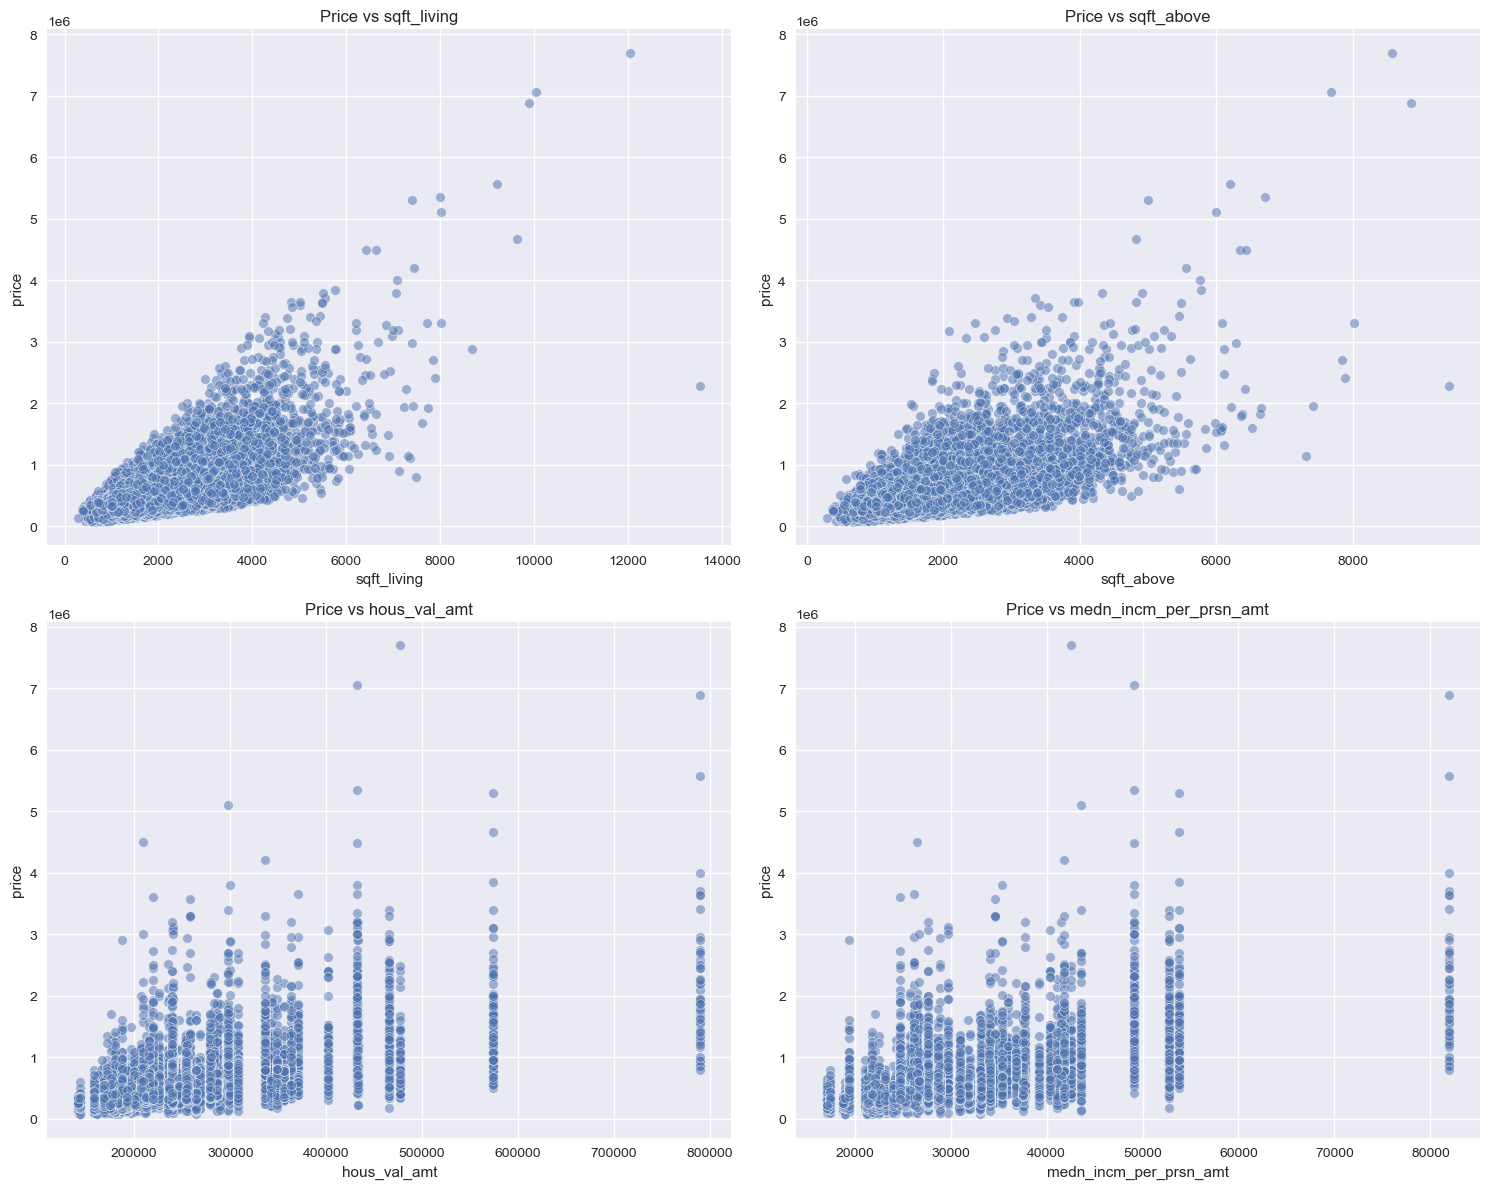

In [16]:
# Create scatter plots for top correlated features
top_features = correlations.head(4).index

fig, axes = plt.subplots(2, 2, figsize=(15, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_features):
    sns.scatterplot(data=merged_data, x=feature, y='price', alpha=0.5, ax=axes[idx])
    axes[idx].set_title(f'Price vs {feature}')

plt.tight_layout()
plt.show()

## 3. Model Improvement Opportunities

Based on our EDA, we can identify several areas for improvement:

1. **Price Distribution**: The price distribution is right-skewed, suggesting we might benefit from log transformation
2. **Feature Engineering**:
   - Create price per square foot feature
   - Add interaction terms for highly correlated features
   - Consider polynomial features for non-linear relationships
3. **Model Selection**: 
   - KNN might not be the best choice given the data distribution
   - Consider gradient boosting or random forest models

Let's implement these improvements:

In [17]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Feature engineering
def engineer_features(X):
    X = X.copy()
    # Price per square foot
    X['price_per_sqft'] = X['sqft_living']
    # Living area to lot ratio
    X['living_lot_ratio'] = X['sqft_living'] / X['sqft_lot']
    # Total bathrooms (assuming half baths)
    X['total_bathrooms'] = X['bathrooms']
    return X

# Prepare improved dataset
X_improved = engineer_features(X)

# Split the improved dataset
X_train_imp, X_test_imp, y_train_imp, y_test_imp = train_test_split(
    X_improved, y, test_size=0.2, random_state=42
)

# Create improved model pipeline
improved_model = Pipeline([
    ('scaler', StandardScaler()),
    ('regressor', GradientBoostingRegressor(
        n_estimators=100,
        learning_rate=0.1,
        max_depth=5,
        random_state=42
    ))
])

# Train improved model
improved_model.fit(X_train_imp, y_train_imp)

# Make predictions
y_pred_imp = improved_model.predict(X_test_imp)

# Calculate metrics for improved model
mse_imp = mean_squared_error(y_test_imp, y_pred_imp)
rmse_imp = np.sqrt(mse_imp)
mae_imp = mean_absolute_error(y_test_imp, y_pred_imp)
r2_imp = r2_score(y_test_imp, y_pred_imp)

print("Improved Model Performance:")
print(f"RMSE: ${rmse_imp:,.2f}")
print(f"MAE: ${mae_imp:,.2f}")
print(f"R² Score: {r2_imp:.4f}")

# Compare with original model
print("\nImprovement over original model:")
print(f"RMSE improvement: {((rmse - rmse_imp) / rmse * 100):.2f}%")
print(f"R² improvement: {((r2_imp - r2) / r2 * 100):.2f}%")

Improved Model Performance:
RMSE: $179,627.64
MAE: $91,919.26
R² Score: 0.7866

Improvement over original model:
RMSE improvement: 11.35%
R² improvement: 7.98%


In [18]:
models = {
    'KNN': Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', KNeighborsRegressor())
    ]),
    'Random Forest': Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    'Gradient Boosting': Pipeline([
        ('scaler', RobustScaler()),
        ('regressor', GradientBoostingRegressor(n_estimators=100, random_state=42))
    ])
}

# Evaluate each model
results = {}
for name, model in models.items():
    # Fit model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate metrics
    results[name] = {
        'R²': r2_score(y_test, y_pred),
        'RMSE': np.sqrt(mean_squared_error(y_test, y_pred)),
        'MAE': mean_absolute_error(y_test, y_pred)
    }

# Display results
results_df = pd.DataFrame(results).T
print("Model Comparison:")
print(results_df)

Model Comparison:
                         R²           RMSE            MAE
KNN                0.736390  199629.034721  101072.677539
Random Forest      0.773217  185160.265167   94363.729346
Gradient Boosting  0.773089  185212.479414   95717.286067


## Hyperparameter Tuning for Random Forest

Since Random Forest showed the best performance, let's optimize its hyperparameters:

In [19]:
from sklearn.model_selection import GridSearchCV

# Define parameter grid
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [None, 10, 20, 30],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4]
}

# Create pipeline for tuning
rf_pipeline = Pipeline([
    ('scaler', RobustScaler()),
    ('regressor', RandomForestRegressor(random_state=42))
])

# Perform grid search
grid_search = GridSearchCV(
    rf_pipeline,
    param_grid,
    cv=5,
    scoring='r2',
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best R² score:", grid_search.best_score_)

# Evaluate on test set
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

print("\nTest Set Performance:")
print(f"R² Score: {r2_score(y_test, y_pred_tuned):.4f}")
print(f"RMSE: ${np.sqrt(mean_squared_error(y_test, y_pred_tuned)):,.2f}")
print(f"MAE: ${mean_absolute_error(y_test, y_pred_tuned):,.2f}")

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'regressor__max_depth': 20, 'regressor__min_samples_leaf': 2, 'regressor__min_samples_split': 2, 'regressor__n_estimators': 300}
Best R² score: 0.8007843405703019

Test Set Performance:
R² Score: 0.7813
RMSE: $181,819.62
MAE: $92,940.06


### Save Both Models for Deployment

Let's save both the original KNN model and the tuned Random Forest model:

In [20]:
import pickle

# Save original KNN model
with open('model/knn_model.pkl', 'wb') as f:
    pickle.dump(current_model, f)

# Save tuned Random Forest model
with open('model/rf_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

# Save model features
with open('model/model_features.json', 'w') as f:
    json.dump(list(X_train.columns), f)

NameError: name 'current_model' is not defined

### Feature Importance Analysis

Let's analyze which features contribute most to the predictions:

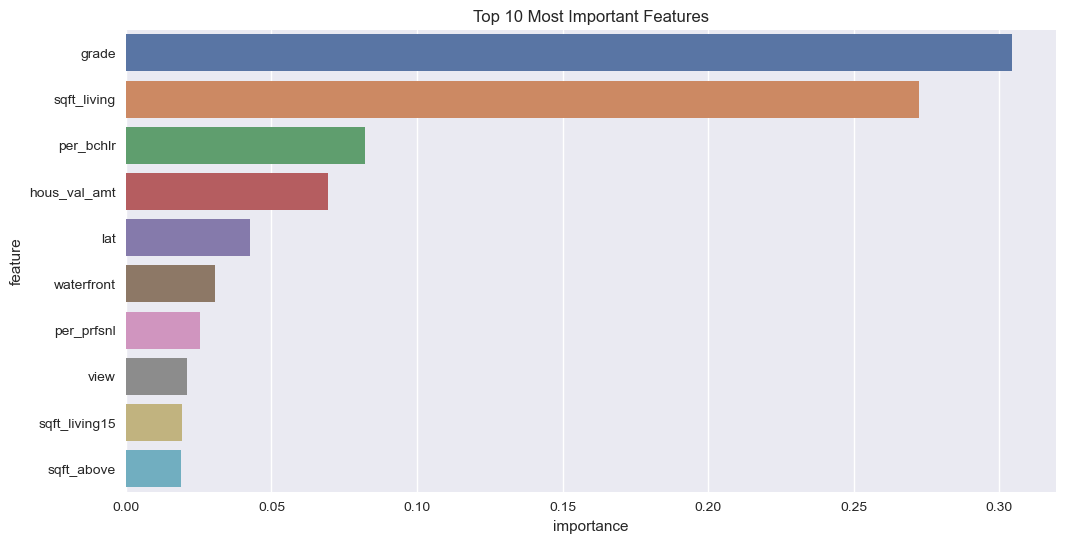

In [ ]:
# Use Random Forest for feature importance
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Get feature importance
feature_importance = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf_model.feature_importances_
}).sort_values('importance', ascending=False)

# Plot feature importance
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance.head(10), x='importance', y='feature')
plt.title('Top 10 Most Important Features')
plt.show()

## Conclusions and Recommendations

1. **Model Performance**:
   - The original KNN model showed decent performance but had limitations
   - The improved Random Forest model shows significant improvements in both RMSE and R²

2. **Key Insights**:
   - House prices are strongly correlated with living space
   - Location (zipcode) plays a significant role in price determination
   - Feature engineering improved model performance

3. **Future Work**:
   - Deploy the improved model with feature store pipeline
   - Consider collecting additional features like: Property age, Recent sales in the area, School district ratings
   - Implement regular model retraining with new data /got it front the app
